# Advanced Visualizations

### Importing the libraries

In [11]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

### Loading the Dataset

In [2]:
df = pd.read_parquet('final_data/final_modeling_data.parquet')

### Plotting the Age Pyramid

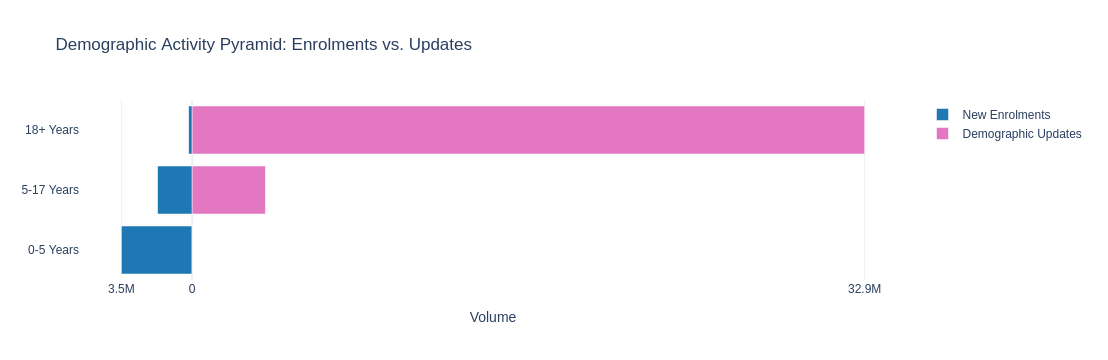

In [21]:
def plot_age_pyramid(df_enrol, df_update):
    # 1. Prepare Data    
    # RELOADING Cleaned Files for granular age access
    e = pd.read_parquet('enrolment_cleaned.parquet')
    u = pd.read_parquet('demographic_cleaned.parquet')
    
    # Define groups
    age_groups = ['age_0_5', 'age_5_17', 'age_18_greater']
    age_group = ['demo_age_5_17', 'demo_age_17_']
    
    # Sum totals
    enrol_counts = [e[col].sum() for col in age_groups]
    update_counts = [u[col].sum() for col in age_group]
    update_counts.insert(0, 0)
    
    # 2. Create Pyramid
    # Left side -> Enrolments
    # Right side -> Updates
    
    y_age_labels = ['0-5 Years', '5-17 Years', '18+ Years']

    fig = go.Figure()

    # Left Side (Enrolments)
    fig.add_trace(go.Bar(
        y=y_age_labels,
        x=[-c for c in enrol_counts], # Negative to flip left
        name='New Enrolments',
        orientation='h',
        marker=dict(color='#1f77b4')
    ))

    # Right Side (Updates)
    fig.add_trace(go.Bar(
        y=y_age_labels,
        x=update_counts,
        name='Demographic Updates',
        orientation='h',
        marker=dict(color='#e377c2')
    ))

    # 3. Formatting
    fig.update_layout(
        title='Demographic Activity Pyramid: Enrolments vs. Updates',
        barmode='overlay', # Aligns them on the center axis
        xaxis=dict(
            tickvals=[-max(enrol_counts), 0, max(update_counts)],
            ticktext=[f"{max(enrol_counts)/1e6:.1f}M", "0", f"{max(update_counts)/1e6:.1f}M"],
            title='Volume'
        ),
        template='plotly_white'
    )
    
    fig.show()

# Run the function
plot_age_pyramid(None, None)

### Sankey Diagram

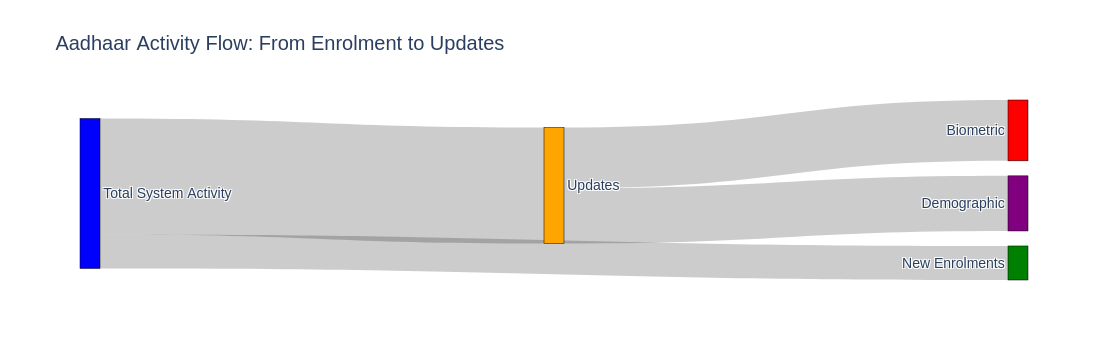

In [8]:
def plot_project_sankey(df):
    # 1. Calculate Totals for Nodes
    total_enrol = df['Enrolment_Count'].sum()
    total_demo = df['Demo_Update_Count'].sum()
    total_bio = df['Bio_Update_Count'].sum()
    total_activity = total_enrol + total_demo + total_bio
    
    # 2. Define Nodes (The "Stops" in the flow)
    # Source: "Total Activity"
    # Targets: "Enrolment", "Updates"
    # Sub-Targets of Updates: "Demographic", "Biometric"
    
    label_list = ["Total System Activity", "New Enrolments", "Updates", "Demographic", "Biometric"]
    
    # 3. Define Links (Source Index -> Target Index)
    # Indices: 0=Root, 1=Enrol, 2=Updates, 3=Demo, 4=Bio
    
    sources = [0, 0, 2, 2] # From Root->Enrol, Root->Updates, Updates->Demo, Updates->Bio
    targets = [1, 2, 3, 4]
    values  = [total_enrol, (total_demo + total_bio), total_demo, total_bio]
    
    # 4. Create Plot
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = label_list,
            color = ["blue", "green", "orange", "purple", "red"]
        ),
        link = dict(
            source = sources,
            target = targets,
            value = values
        ))])

    fig.update_layout(title_text="Aadhaar Activity Flow: From Enrolment to Updates", font_size=14)
    fig.show()

plot_project_sankey(df)

### Some important graphs

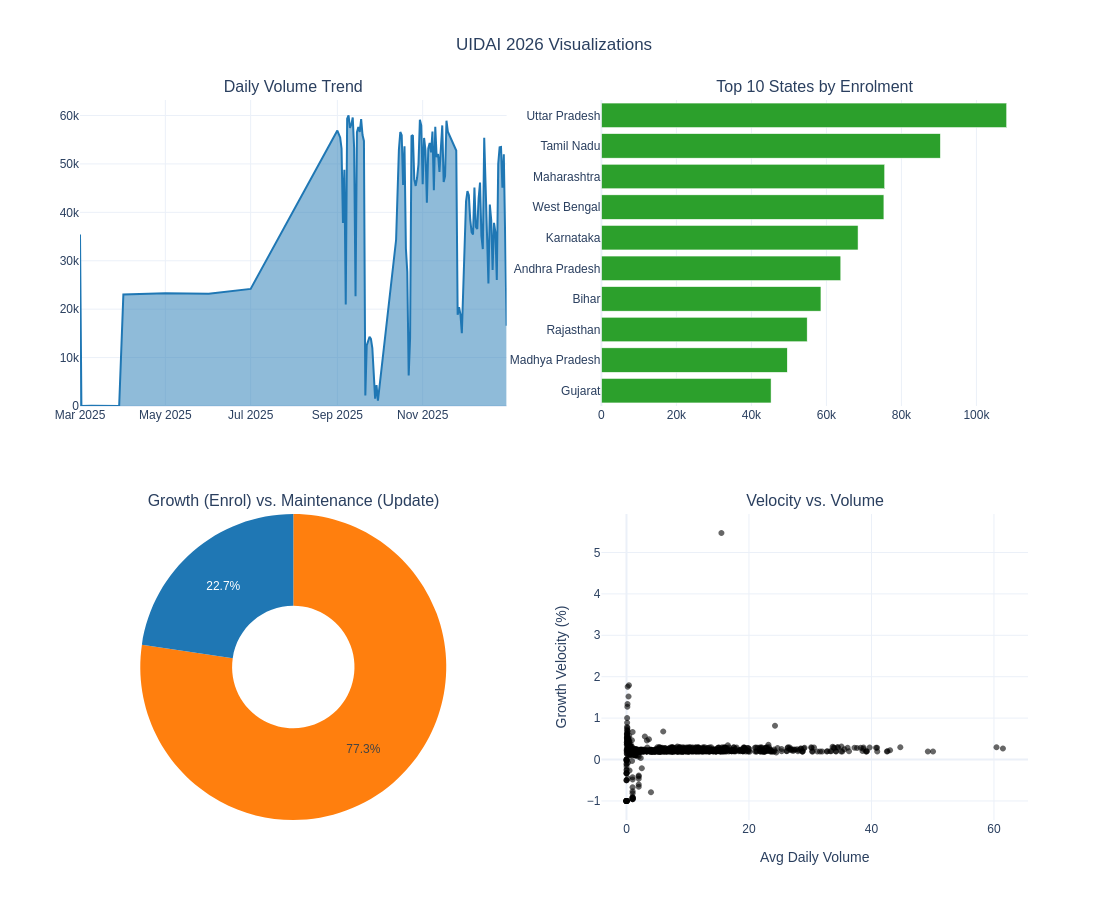

In [20]:
def create_graphs(df):
    # --- DATA PREPARATION ---
    # 1. Daily Trend (Aggregated)
    daily_vol = df.groupby('date')[['Enrolment_Count', 'Bio_Update_Count', 'Demo_Update_Count']].sum().reset_index()
    daily_vol['Total'] = daily_vol['Enrolment_Count'] + daily_vol['Bio_Update_Count'] + daily_vol['Demo_Update_Count']
    
    # 2. State Leaderboard
    state_vol = df.groupby('state')['Enrolment_Count'].sum().sort_values(ascending=True).tail(10) # Tail for horiz bar
    
    # 3. Activity Mix
    total_e = df['Enrolment_Count'].sum()
    total_u = df['Bio_Update_Count'].sum() + df['Demo_Update_Count'].sum()
    
    # 4. District Health (Sampled for performance)
    # We color code by "Cluster" to show we did advanced ML
    sample = df.groupby(['district', 'District_Cluster']).agg({
        'Enrolment_Count': 'mean', 
        'Enrol_Velocity': 'mean'
    }).reset_index()
    
    # --- DASHBOARD CREATION ---
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "scatter"}, {"type": "bar"}],
               [{"type": "domain"}, {"type": "scatter"}]], 
        subplot_titles=(
            "Daily Volume Trend", 
            "Top 10 States by Enrolment", 
            "Growth (Enrol) vs. Maintenance (Update)", 
            "Velocity vs. Volume"
        ),
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )

    # Q1: National Trend (Line Chart)
    fig.add_trace(go.Scatter(
        x=daily_vol['date'], y=daily_vol['Total'], 
        mode='lines', name='Total Activity',
        line=dict(color='#1f77b4', width=2),
        fill='tozeroy' # Fills area under line for "Volume" feel
    ), row=1, col=1)
    
    # Q2: State Leaderboard (Bar Chart)
    fig.add_trace(go.Bar(
        x=state_vol.values, y=state_vol.index, 
        orientation='h', name="Volume", 
        marker_color='#2ca02c'
    ), row=1, col=2)
    
    # Q3: Activity Mix (Donut Chart)
    fig.add_trace(go.Pie(
        labels=['New Enrolments', 'Updates (Bio+Demo)'], 
        values=[total_e, total_u],
        hole=0.4, # Donut style looks more modern
        marker=dict(colors=['#1f77b4', '#ff7f0e']),
        name="Activity Type"
    ), row=2, col=1)
    
    # Q4: District Health (Scatter Plot)
    # Map clusters to colors
    colors = {'Low Volume': 'red', 'Medium Volume': 'blue', 'High Volume': 'green'}
    
    # We iterate to allow legend grouping if needed, or just plot all
    fig.add_trace(go.Scatter(
        x=sample['Enrolment_Count'], 
        y=sample['Enrol_Velocity'], 
        mode='markers', 
        name='District',
        text=sample['district'], # Hover text
        marker=dict(color=sample['District_Cluster'].map({'Cluster 0': 'red', 'Cluster 1': 'blue', 'Cluster 2': 'green'}), size=6, opacity=0.6)
    ), row=2, col=2)

    # --- FINAL POLISH ---
    fig.update_layout(
        height=900, width=1300, 
        title_text="UIDAI 2026 Visualizations", 
        title_x=0.5, # Center title
        template="plotly_white",
        showlegend=False # Hide legend to keep it clean (charts are self-explanatory)
    )
    
    # Add axis labels for scatter plot context
    fig.update_xaxes(title_text="Avg Daily Volume", row=2, col=2)
    fig.update_yaxes(title_text="Growth Velocity (%)", row=2, col=2)

    fig.show()
    
create_graphs(df)

In [19]:
import pandas as pd

def generate_slide_stats(df):
    print("--- 📊 STATISTICS FOR PRESENTATION SLIDES ---")
    
    # 1. VOLUME STATS (Slide 2)
    total_enrol = df['Enrolment_Count'].sum()
    total_updates = df['Bio_Update_Count'].sum() + df['Demo_Update_Count'].sum()
    print(f"\n[Slide 2] Total Processed Volume: {(total_enrol + total_updates):,.0f}")
    print(f"[Slide 2] Enrolment vs Update Split: {total_enrol/(total_enrol+total_updates):.1%} Enrolments")

    # 2. GEOGRAPHIC INSIGHTS (Slide 6)
    # Top State
    top_state = df.groupby('state')['Enrolment_Count'].sum().idxmax()
    print(f"\n[Slide 6] Top Performing State: {top_state}")
    
    # 3. ML MODEL FINDINGS (Slide 9 & 10)
    # Assuming we have the 'Is_Low_Compliance' flag from Week 3
    # If not, we quickly recalculate a proxy
    if 'Is_Low_Compliance' not in df.columns:
        threshold = df['Bio_Update_Count'].quantile(0.25)
        df['Is_Low_Compliance'] = (df['Bio_Update_Count'] <= threshold)
        
    high_risk_count = df['Is_Low_Compliance'].sum()
    print(f"\n[Slide 10] High Risk Districts Identified: {high_risk_count} ({high_risk_count/len(df):.1%})")
    
    # 4. VELOCITY INSIGHTS (Slide 5)
    # Districts growing faster than 50% week-over-week
    if 'Enrol_Velocity' in df.columns:
        fast_growers = df[df['Enrol_Velocity'] > 0.5]['district'].nunique()
        print(f"\n[Slide 5] Hyper-Growth Districts (>50% WoW): {fast_growers}")

# Load data and run
try:
    df_final = pd.read_parquet('final_data/final_modeling_data.parquet')
    generate_slide_stats(df_final)
except FileNotFoundError:
    print("❌ Run Week 2 & 3 code first to generate the dataset.")

--- 📊 STATISTICS FOR PRESENTATION SLIDES ---

[Slide 2] Total Processed Volume: 4,320,008
[Slide 2] Enrolment vs Update Split: 22.7% Enrolments

[Slide 6] Top Performing State: Uttar Pradesh

[Slide 10] High Risk Districts Identified: 25895 (27.3%)

[Slide 5] Hyper-Growth Districts (>50% WoW): 941
